## agent 와 RAG 를 사용해서 챗봇 만들어보기

In [1]:
!pip install langchain_openai --quiet
!pip install langchain-community --quiet
!pip install pypdf --quiet
!pip install faiss-cpu --quiet
!pip install -qU "langchain-community>=0.2.11" tavily-python --quiet
!pip install langsmith --quiet

In [2]:
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [29]:
# API_KEY 가져오기


import os
from getpass import getpass

os.environ["OPENAI_API_KEY"] = getpass("OpenAI API key 입력: ")

#### 아래는 사용할 예시 데이터

In [30]:
recipes_data = [
    {
        "food_name": "김치찌개",
        "ingredients": {
            "김치": "200g",
            "돼지고기": "150g",
            "두부": "100g",
            "양파": "1개",
            "마늘": "2쪽",
            "고춧가루": "1큰술",
        },
        "time": "30분",
        "per": "2인분",
        "recipe": [
            "1. 돼지고기와 양파를 썰어 볶는다.",
            "2. 김치를 넣고 함께 볶은 후, 물을 부어 끓인다.",
            "3. 두부와 마늘을 넣고 끓이다가 고춧가루를 추가한다.",
            "4. 끓인 후 소금과 간장으로 간을 맞추고, 30분 정도 끓인다.",
        ]
    },
    {
        "food_name": "된장찌개",
        "ingredients": {
            "된장": "3큰술",
            "두부": "200g",
            "호박": "1/2개",
            "양파": "1개",
            "마늘": "2쪽",
            "고춧가루": "1큰술",
        },
        "time": "25분",
        "per": "2인분",
        "recipe": [
            "1. 된장과 물을 섞어 끓인다.",
            "2. 양파와 호박을 썰어 넣고 끓인다.",
            "3. 두부와 마늘을 넣고 10분 정도 끓인다.",
            "4. 간을 맞추고 고춧가루로 마무리한다.",
        ]
    },
    {
        "food_name": "미역국",
        "ingredients": {
            "미역(마른것)": "5줌 (20g)",
            "쇠고기(양지머리)": "120g",
            "물": "8컵 (1,600ml)",
            "재래간장": "1과 1/2큰술 (22ml)",
            "마늘(다진 마늘)": "1큰술 (10g)",
            "소금": "작은술 (3g)",
            "참기름": "작은술 (5ml)",
        },
        "time": "30분",
        "per": "4인분",
        "recipe": [
            "1. 마른 미역은 찬물에 담가 10분간 불린다. 찬물에 바락바락 씻어 거품이 나오지 않을 때까지 헹군다.",
            "2. 물기를 꼭 짠 후 적당한 크기로 자른 후 재래간장 1/2큰술을 넣고 조물조물 무친다.",
            "3. 쇠고기는 한입 크기로 썬 후 달군 냄비에 참기름을 두르고 쇠고기, 마늘을 넣어 볶다가 쇠고기가 거의 익으면 미역을 넣고 볶는다.",
            "4. 03에 물을 넣고 한소끔 끓인다. 재래간장과 소금으로 간하고 더 끓인다. (물 대신 쌀뜨물을 넣으면 더욱 구수하고 맛있는 미역국을 만들 수 있다.)",
        ]
    },
    # 추가된 연근조림 레시피
    {
        "food_name": "연근조림",
        "ingredients": {
            "연근": "120g",
            "간장": "17ml",
            "식초": "1/2큰술 (7ml)",
            "양념 간장": "2큰술 (30ml)",
            "양념 물엿": "1큰술 (10g)",
            "양념 설탕": "1큰술 (10g)",
            "양념 식용유": "1/2큰술 (7ml)",
            "참기름": "1/2작은술 (2ml)",
            "통깨": "1/2작은술 (2g)",
        },
        "time": "25분",
        "per": "2인분",
        "recipe": [
            "1. 연근 껍질은 벗기고 0.5cm 두께로 썬다. 냄비에 물 1컵(200ml), 식초, 연근을 넣고 연근이 반쯤 익을 때까지 데친다. 체에 밭쳐 물기를 뺀다. (연근을 식촛물에 데쳐내어 아린맛을 없애고 조리는 시간을 줄일 수 있다.)",
            "2. 냄비에 물 1컵(200ml)과 양념 재료, 연근을 넣고 조린다.",
            "3. 국물이 거의 없어질 때까지 조린 뒤 불을 끄고 참기름과 통깨를 넣고 버무린다.",
        ]
    },
]


In [31]:
import json

with open('recipes_data.json','w',encoding='utf-8') as json_file:
    json.dump(recipes_data,json_file, ensure_ascii=False,indent=4)
    
print("레시피 데이터가 'recipes_data.json' 파일로 저장되었습니다.")

레시피 데이터가 'recipes_data.json' 파일로 저장되었습니다.


In [32]:
# 1. llm 모델 불러오기
llm = ChatOpenAI(model="gpt-4o-mini")

In [33]:
# 2. 문서 불러오기
from langchain.schema import Document

# JSON 파일 로드 함수
def load_json_as_documents(file_path):
    """
    JSON 파일을 읽어 LangChain의 Document 객체 리스트로 변환
    """
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    
    # JSON 데이터 -> LangChain Document로 변환
    documents = []
    for item in data:
        # 각 항목을 Document 객체로 변환
        content = json.dumps(item, ensure_ascii=False)  # JSON 데이터를 문자열로 직렬화
        documents.append(Document(page_content=content))
    
    return documents

# JSON 파일 경로
file_path = "/Users/t2023-m0072/Desktop/CH-3_LLM-RAG_Team_12_project/personal_work/차아인/recipes_data.json"

# JSON 데이터를 문서로 로드
docs = load_json_as_documents(file_path)

# 문서 확인
print(f"Loaded {len(docs)} documents.")
for doc in docs[:3]:  # 샘플 출력
    print(doc)
    
    

'''with open('recipes_data.json', 'r', encoding='utf-8') as json_file:
    loader = json.load(json_file)

print(loader)'''

Loaded 4 documents.
page_content='{"food_name": "김치찌개", "ingredients": {"김치": "200g", "돼지고기": "150g", "두부": "100g", "양파": "1개", "마늘": "2쪽", "고춧가루": "1큰술"}, "time": "30분", "per": "2인분", "recipe": ["1. 돼지고기와 양파를 썰어 볶는다.", "2. 김치를 넣고 함께 볶은 후, 물을 부어 끓인다.", "3. 두부와 마늘을 넣고 끓이다가 고춧가루를 추가한다.", "4. 끓인 후 소금과 간장으로 간을 맞추고, 30분 정도 끓인다."]}'
page_content='{"food_name": "된장찌개", "ingredients": {"된장": "3큰술", "두부": "200g", "호박": "1/2개", "양파": "1개", "마늘": "2쪽", "고춧가루": "1큰술"}, "time": "25분", "per": "2인분", "recipe": ["1. 된장과 물을 섞어 끓인다.", "2. 양파와 호박을 썰어 넣고 끓인다.", "3. 두부와 마늘을 넣고 10분 정도 끓인다.", "4. 간을 맞추고 고춧가루로 마무리한다."]}'
page_content='{"food_name": "미역국", "ingredients": {"미역(마른것)": "5줌 (20g)", "쇠고기(양지머리)": "120g", "물": "8컵 (1,600ml)", "재래간장": "1과 1/2큰술 (22ml)", "마늘(다진 마늘)": "1큰술 (10g)", "소금": "작은술 (3g)", "참기름": "작은술 (5ml)"}, "time": "30분", "per": "4인분", "recipe": ["1. 마른 미역은 찬물에 담가 10분간 불린다. 찬물에 바락바락 씻어 거품이 나오지 않을 때까지 헹군다.", "2. 물기를 꼭 짠 후 적당한 크기로 자른 후 재래간장 1/2큰술을 넣고 조물조물 무친다.", "3. 쇠고기는 한입 크기로 썬 후 달군 냄비에 참기름을

"with open('recipes_data.json', 'r', encoding='utf-8') as json_file:\n    loader = json.load(json_file)\n\nprint(loader)"

In [34]:
# 3. 문서 chunking 하기
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)

In [35]:
# 자른 청크 임베딩
embeddings = OpenAIEmbeddings(model="text-embedding-ada-002")

In [36]:
# vectorstore 구축
vectorstore = FAISS.from_documents(documents=splits, embedding=embeddings)


In [37]:
# retriever 구축
retriever = vectorstore.as_retriever()


In [38]:
# 7. retriever tool 구축
retriever_tool = create_retriever_tool(
    retriever, # 검색할 대상인 리트리버
    "stock", # 검색 tool의 이름
    "요리, 음식과 관련된 질문이 입력되면 이 도구를 사용합니다." ####@@@!!!!!!!tool 을 정하는 프롬프트 
)

In [39]:
# travily api key
import os
import getpass

os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API key:\n")

In [40]:

############ 8. 인터넷 검색 tool 구축하기]
search = TavilySearchResults()

############ 9. LLM이 선택할 tool을 리스트로 담기
tools = [search, retriever_tool]
prompt = hub.pull("hwchase17/openai-functions-agent")
agent = create_openai_tools_agent(llm, tools, prompt)

/opt/anaconda3/envs/LLM_RAG/lib/python3.12/site-packages/langsmith/client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [41]:
# 9. 에이전트 실행기 만들기
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

In [42]:
# 10. 질문 실행하기

response = agent_executor.invoke({"input":"김치로 만들 수 있는 요리를 알려줘"})

print(response)



> Entering new AgentExecutor chain...

Invoking: `stock` with `{'query': '김치 요리'}`


{"food_name": "김치찌개", "ingredients": {"김치": "200g", "돼지고기": "150g", "두부": "100g", "양파": "1개", "마늘": "2쪽", "고춧가루": "1큰술"}, "time": "30분", "per": "2인분", "recipe": ["1. 돼지고기와 양파를 썰어 볶는다.", "2. 김치를 넣고 함께 볶은 후, 물을 부어 끓인다.", "3. 두부와 마늘을 넣고 끓이다가 고춧가루를 추가한다.", "4. 끓인 후 소금과 간장으로 간을 맞추고, 30분 정도 끓인다."]}

{"food_name": "미역국", "ingredients": {"미역(마른것)": "5줌 (20g)", "쇠고기(양지머리)": "120g", "물": "8컵 (1,600ml)", "재래간장": "1과 1/2큰술 (22ml)", "마늘(다진 마늘)": "1큰술 (10g)", "소금": "작은술 (3g)", "참기름": "작은술 (5ml)"}, "time": "30분", "per": "4인분", "recipe": ["1. 마른 미역은 찬물에 담가 10분간 불린다. 찬물에 바락바락 씻어 거품이 나오지 않을 때까지 헹군다.", "2. 물기를 꼭 짠 후 적당한 크기로 자른 후 재래간장 1/2큰술을 넣고 조물조물 무친다.", "3. 쇠고기는 한입 크기로 썬 후 달군 냄비에 참기름을 두르고 쇠고기, 마늘을 넣어 볶다가 쇠고기가 거의 익으면 미역을 넣고 볶는다.", "4. 03에 물을 넣고 한소끔 끓인다. 재래간장과 소금으로 간하고 더 끓인다. (물 대신 쌀뜨물을 넣으면 더욱 구수하고 맛있는 미역국을 만들 수 있다.)"]}

{"food_name": "된장찌개", "ingredients": {"된장": "3큰술", "두부": "200g", "호박": "1/2개", "양파": "1개", "마늘": "2

### 여기까지는 agent + RAG 를 이용하여 챗봇을 만들어 봄

---

### 이 이후는 프롬프트 템플릿 구축한 것 - 아직 만드는 중ㅇ



In [43]:
# 프롬프트 템플릿 구축하기
prompt = prompt = ChatPromptTemplate.from_template("""
너는 사용자가 입력한 [재료]에 따라 관련 요리를 알려주는 요리사야.
친절하고 전문적인 말투로 응답해.
이 재료들로 만들 수 있는 요리의 레시피를 알려줘.
- 요리의 이름
- 필요한 재료
- 요리 방법
- 조리 시간
- 인분 수


{context}
질문:
{question}
""")

In [44]:
llm = ChatOpenAI(model="gpt-4o-mini")


In [45]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [46]:
print(rag_chain.invoke("김치로 만들 수 있는 요리가 있을까?"))

네, 김치로 만들 수 있는 대표적인 요리 중 하나인 **김치찌개**를 소개해드리겠습니다. 아래는 김치찌개의 레시피입니다.

### 김치찌개

#### 필요한 재료
- 김치: 200g
- 돼지고기: 150g
- 두부: 100g
- 양파: 1개
- 마늘: 2쪽
- 고춧가루: 1큰술
- 물: 적당량

#### 요리 방법
1. 돼지고기와 양파를 먹기 좋은 크기로 썰어 볶습니다.
2. 볶은 돼지고기와 양파에 김치를 추가하여 함께 볶습니다.
3. 김치가 어느 정도 익으면 물을 부어 끓입니다.
4. 끓는 국물에 두부와 다진 마늘을 넣고, 고춧가루를 추가하여 다시 끓입니다.
5. 마지막으로 소금과 간장으로 간을 맞추고, 약 30분 정도 끓입니다.

#### 조리 시간
- 약 30분

#### 인분 수
- 2인분

따뜻하고 얼큰한 김치찌개는 밥과 함께 즐기기 좋은 메뉴입니다. 맛있게 요리해보세요!


## 문제점
* 입력한 데이터셋을 바탕으로 답변을 생성하게 하려고 했는데 입력한 데이터셋과는 다른 내용을 알려주고 있음

---

    "food_name": "김치찌개",
        "ingredients": {
            "김치": "200g",
            "돼지고기": "150g",
            "두부": "100g",
            "양파": "1개",
            "마늘": "2쪽",
            "고춧가루": "1큰술",
        },
        "time": "30분",
        "per": "2인분",
        "recipe": [
            "1. 돼지고기와 양파를 썰어 볶는다.",
            "2. 김치를 넣고 함께 볶은 후, 물을 부어 끓인다.",
            "3. 두부와 마늘을 넣고 끓이다가 고춧가루를 추가한다.",
            "4. 끓인 후 소금과 간장으로 간을 맞추고, 30분 정도 끓인다.",


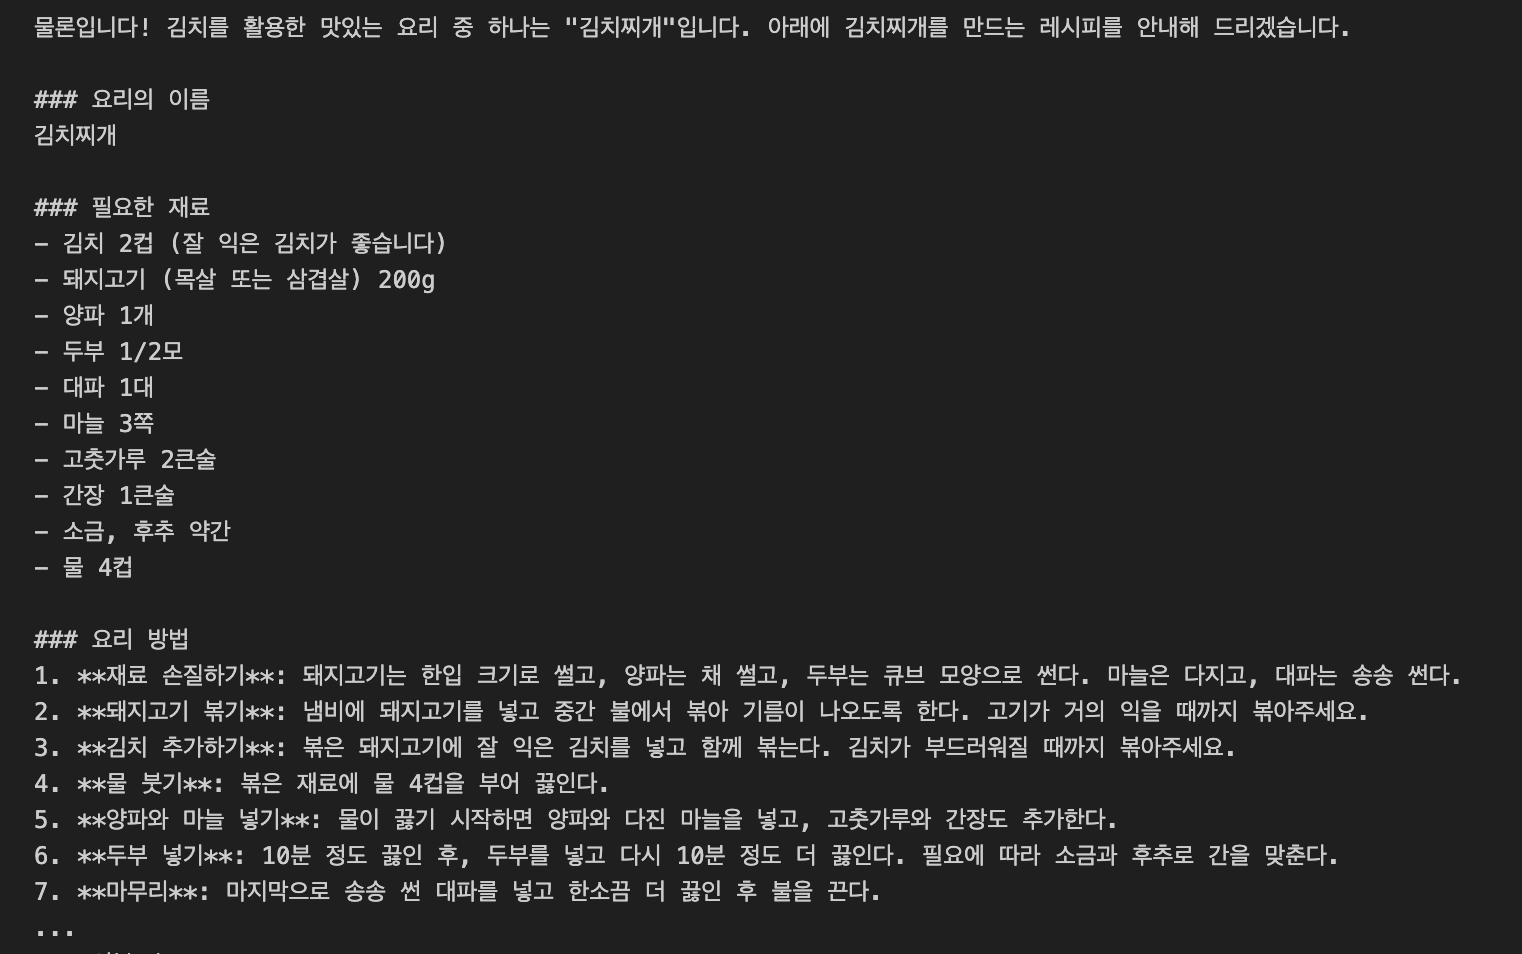